In [1]:
# import the libraries as shown below
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
#import splitfolders


In [3]:
#input_folders= r"dataset"

In [4]:
#splitfolders.ratio(input_folders,output='dataset1',seed=50,ratio=(.8,.1,.1), group_prefix=None)

Copying files: 7320 files [00:16, 451.01 files/s]


In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"dataset1\train",
    seed=123,
    shuffle=True,
    image_size=(224,224),
    batch_size=32
)

Found 5830 files belonging to 5 classes.


In [3]:
class_names = dataset.class_names
class_names

['Chickenpox', 'Healthy skin', 'Measles', 'Monkeypox', 'Small_Pox']

In [4]:
for image_batch, labels_batch in dataset.take(5):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[3 4 0 4 4 4 4 4 3 4 3 0 3 3 3 3 4 0 0 4 3 0 1 0 0 1 3 1 4 3 1 0]
(32, 224, 224, 3)
[0 3 4 4 4 4 1 4 2 4 3 4 1 4 4 0 3 3 3 3 4 0 1 4 1 3 4 3 0 3 1 4]
(32, 224, 224, 3)
[1 4 0 1 4 3 0 4 3 4 4 0 4 4 3 4 3 3 4 0 2 4 4 0 0 2 4 3 3 3 3 4]
(32, 224, 224, 3)
[0 1 0 1 0 4 0 4 3 1 4 3 1 0 0 1 0 2 1 0 4 4 3 0 4 1 4 0 4 1 1 3]
(32, 224, 224, 3)
[4 1 2 2 4 2 4 1 3 0 3 4 0 3 0 2 4 0 3 4 2 0 3 1 3 4 3 4 1 4 0 1]


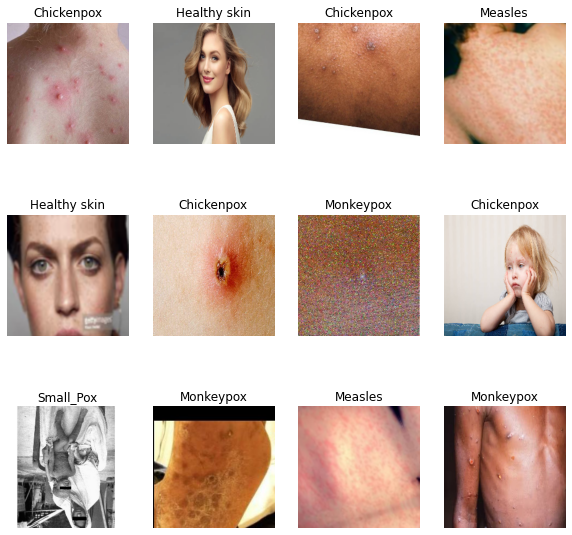

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(5):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [7]:
train_path =  r"dataset1/train"
valid_path =  r"dataset1/val"

In [8]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [10]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)

In [11]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [12]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=10,
                                   horizontal_flip = True)

In [15]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.3,
        zoom_range = 0.2,
        rotation_range=10,
        horizontal_flip=True)

validation_generator = validation_datagen.flow_from_directory(
        r"dataset1\val",
        target_size=(224,224),
        batch_size=32,
        class_mode="sparse"
)

Found 727 images belonging to 5 classes.


In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
training_set = train_datagen.flow_from_directory(r"dataset1\train",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(r"dataset1\test",
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')




Found 5830 images belonging to 5 classes.
Found 730 images belonging to 5 classes.


In [20]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

In [21]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[earlystopping]
)

Epoch 1/100
183/183 [==============================] - 684s 4s/step - loss: 0.7293 - accuracy: 0.7338 - val_loss: 0.4989 - val_accuracy: 0.8315
Epoch 2/100
183/183 [==============================] - 501s 3s/step - loss: 0.4547 - accuracy: 0.8455 - val_loss: 0.4187 - val_accuracy: 0.8562
Epoch 3/100
183/183 [==============================] - 503s 3s/step - loss: 0.3548 - accuracy: 0.8830 - val_loss: 0.3659 - val_accuracy: 0.8836
Epoch 4/100
183/183 [==============================] - 482s 3s/step - loss: 0.2969 - accuracy: 0.8991 - val_loss: 0.4088 - val_accuracy: 0.8562
Epoch 5/100
183/183 [==============================] - 483s 3s/step - loss: 0.2831 - accuracy: 0.9053 - val_loss: 0.2963 - val_accuracy: 0.9082
Epoch 6/100
183/183 [==============================] - 494s 3s/step - loss: 0.2209 - accuracy: 0.9283 - val_loss: 0.2711 - val_accuracy: 0.9288
Epoch 7/100
183/183 [==============================] - 523s 3s/step - loss: 0.1984 - accuracy: 0.9336 - val_loss: 0.3245 - val_accuracy:

In [22]:
scores = model.evaluate(test_set)

23/23 [==============================] - 54s 2s/step - loss: 0.2385 - accuracy: 0.9479


In [23]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

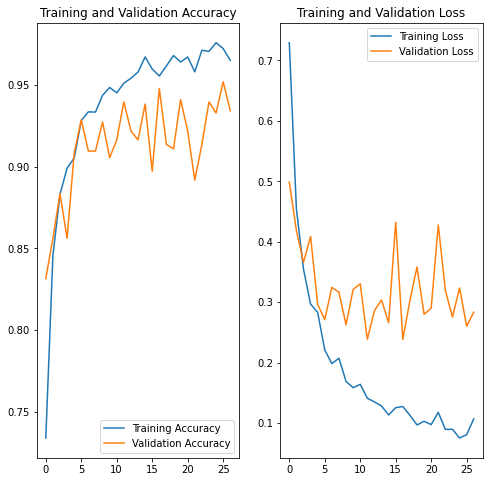

In [24]:
EPOCHS=27
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 105ms/step


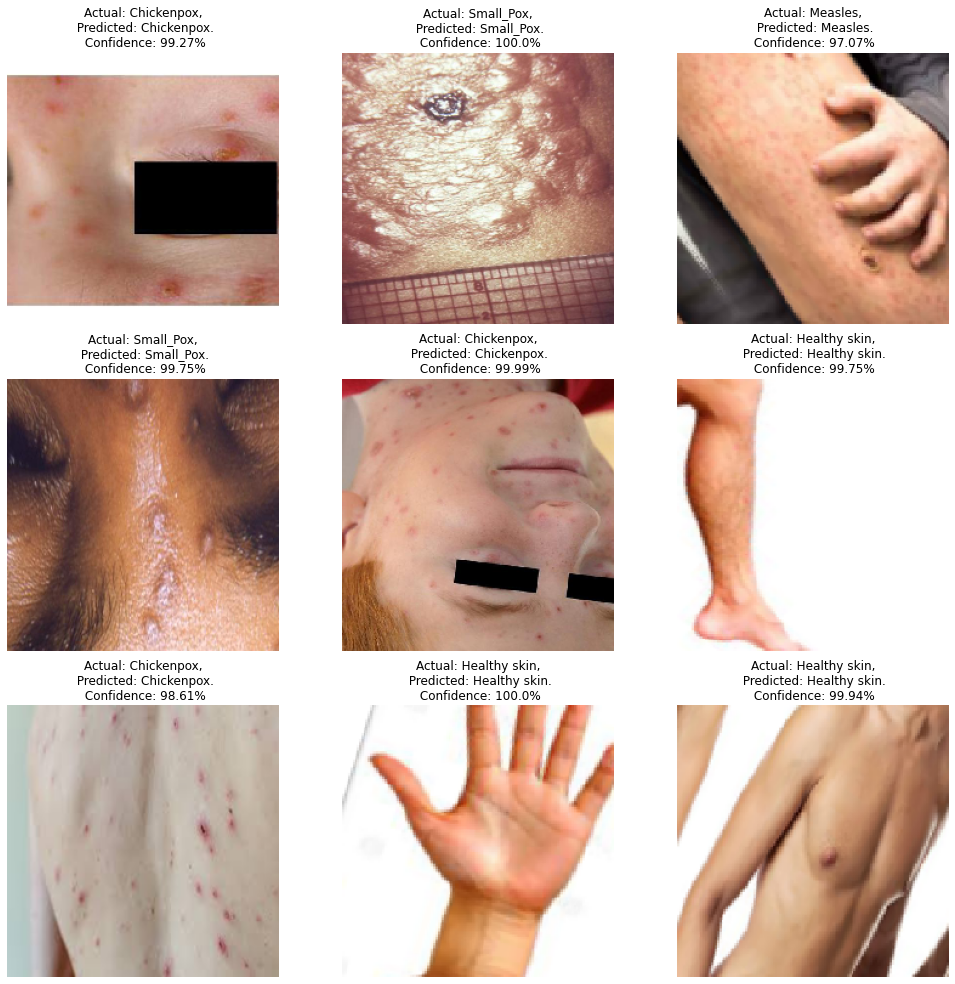

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 17))
for images, labels in test_set:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [28]:
model.save('vgg16_final2.h5')